# Introduction

In this notebook, I tried to implement manuel feature engineering to increase the model(LightGBM) performance by eleminating Higly coorelated variables.


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [180]:
train_data = pd.read_csv('/content/drive/MyDrive/IE-582-Final/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/IE-582-Final/test.csv')
app_train = train_data.copy()
app_test = test_data.copy()


In [181]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

2 columns were label encoded.


In [5]:
target = app_train['default']
df = app_train.drop('default',axis= 1)
df

,loan_application_id,loan_amount,customer_age,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_16,Var_17,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_24,Var_25,Var_26,Var_27,Var_28,Var_29,Var_30,Var_31,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,Var_40,Var_41,Var_42,Var_43,Var_44,Var_45,Var_46,Var_47,Var_48,Var_49,Var_50,Var_51,Var_52,Var_53,Var_54,Var_55,Var_56,Var_57,Var_58,Var_59
0,1,2855.0,25,3,1,1,37,41,5,5,1330,1,4,0,0,0,17,0,0,13000,1,4,1,4,600.0,0,0,600.0,600,37,1,465,0,600,0,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.0,0,0,1,1,0
1,2,1577.0,53,0,0,0,0,26,2,2,1478,1,1,0,0,0,0,0,0,2196,1,1,0,1,0.0,0,0,0.0,0,0,0,0,0,0,0,26.00,203,4300,1,3718,4300,0,0.61,203,4300,3718,203,29,4300,26.00,0,0,0,0,0,0,0.0,0,0,0,1,0
2,3,6858.0,39,4,2,3,55,58,10,10,1060,3,4,0,0,0,0,0,0,5000,3,4,4,4,1500.0,0,2001,2500.0,2000,55,4,4999,0,10000,2001,13.42,521,14000,1,4120,14000,0,0.35,521,14000,4120,521,36,14000,13.42,521,521,700,0,700,0,700.0,0,0,4,6,0
3,4,2434.5,49,3,1,3,98,98,11,11,1218,4,7,0,0,0,92,2000,1,7100,4,6,6,7,2450.0,0,0,2450.0,3900,98,2,0,0,4900,15,0.65,296,8100,1,0,8100,0,0.00,296,8100,0,296,36,8100,0.65,296,296,16350,127,16935,0,8467.5,0,0,0,5,0
4,5,4964.0,47,2,1,1,110,124,15,15,1334,4,6,0,0,0,105,5250,2,3200,4,4,3,6,4100.0,700,0,4100.0,4100,110,1,3116,552,4100,700,21.43,1082,30000,7,38044,81941,0,0.90,1082,30000,38044,2684,225,81941,21.43,1874,2684,3000,142,3400,0,1700.0,0,0,2,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2556,3931.0,47,3,2,2,64,64,18,18,1003,10,13,0,0,0,64,15000,3,28190,10,8,11,13,1200.0,450,0,1200.0,1200,13,1,1192,252,1200,450,3.09,967,33000,3,1726,35094,0,0.74,967,33000,1726,1125,77,35094,3.09,1125,1125,500,491,500,0,500.0,0,0,2,5,0
1711,2559,1995.0,64,3,0,0,127,127,17,17,1406,9,14,0,0,0,41,19500,6,18000,9,6,5,14,1500.0,1250,0,1500.0,1500,127,1,1539,0,1500,1250,7.12,260,8500,2,1897,12000,1,0.26,260,8500,1897,456,69,12000,7.12,456,456,300,0,300,0,300.0,10103,456,0,4,0
1712,2560,3821.0,25,3,0,2,45,45,6,6,1122,1,2,0,0,0,45,0,0,5000,1,2,0,2,1100.0,1914,0,1475.0,1100,19,2,2848,73,2950,1914,3.13,411,10000,1,702,10000,0,0.77,411,10000,702,411,36,10000,3.13,411,411,350,347,350,0,350.0,0,0,0,4,0
1713,2561,3570.0,21,1,4,9,27,27,1,1,1218,0,0,0,0,0,0,0,0,0,0,0,0,0,1100.0,40,0,1100.0,1100,27,1,1098,0,1100,40,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,1,0


## Most coorelated columns with the'default' column

# Yeni Bölüm

In [12]:
# Calculate all correlations in dataframe
corrs = app_train.corr()
corrs = corrs.sort_values('default', ascending = False)

# Ten most positive correlations
print(pd.DataFrame(corrs['default'].head(10)))
print(pd.DataFrame(corrs['default'].tail(10)))

              default
default      1.000000
Var_3        0.224789
Var_2        0.209071
loan_amount  0.109846
Var_39       0.064492
Var_36       0.056071
Var_12       0.051615
Var_13       0.051228
Var_53       0.047768
Var_29       0.039616
               default
Var_33       -0.072666
Var_26       -0.076366
Var_43       -0.079699
Var_22       -0.084528
customer_age -0.100367
Var_47       -0.101612
Var_4        -0.114046
Var_5        -0.116969
Var_27       -0.129461
Var_8        -0.193925


## Looking for collinear columns and deleting higly coorelated variables

In [13]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [14]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  23


In [15]:
train_corrs_removed = app_train.drop(columns = cols_to_remove)
test_corrs_removed = app_test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (1715, 40)
Testing Corrs Removed Shape:  (847, 40)


In [16]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

# Testing the performance 

## LightGBM

In [18]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [142]:
from pandas.core.construction import extract_array
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['loan_application_id']
    test_ids = test_features['loan_application_id']
    
    # Extract the labels for training
    labels = features['default']
    
    # Remove the ids and target
    features = features.drop(columns = ['loan_application_id', 'default'])
    test_features = test_features.drop(columns = ['loan_application_id'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=8, objective = 'binary', 
                                    learning_rate = 0.05, class_weight = 'balanced',
                                   #reg_alpha = 0.5, reg_lambda = 0.5,
                                   feature_fraction=0.6,bagging_fraction=0.6,bagging_freq=10,max_depth=5,
num_leaves=30,
                                   subsample = 0.6, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 30, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'loan_application_id': test_ids, 'default': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [143]:
submission_raw, fi_raw, metrics_raw = model(app_train, app_test)

Training Data Shape:  (1715, 61)
Testing Data Shape:  (847, 61)
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.850903	train's binary_logloss: 0.593043	valid's auc: 0.792338	valid's binary_logloss: 0.557445
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.863627	train's binary_logloss: 0.594124	valid's auc: 0.79014	valid's binary_logloss: 0.56958
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.848768	train's binary_logloss: 0.597718	valid's auc: 0.781573	valid's binary_logloss: 0.572082
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.843821	train's binary_logloss: 0.595066	valid's auc: 0.730385	valid's binary_logloss: 0.590393
Training until validation scores don't imp

In [144]:
metrics_raw

,fold,train,valid
0,0,0.850903,0.792338
1,1,0.863627,0.790140
2,2,0.848768,0.781573
3,3,0.843821,0.730385
4,4,0.870001,0.686880
5,overall,0.855424,0.750068


In [151]:
submission_raw

,loan_application_id,default
0,6,0.492008
1,9,0.535214
2,18,0.417952
3,20,0.353648
4,22,0.405065
...,...,...
842,2551,0.349350
843,2552,0.460342
844,2553,0.521176
845,2557,0.385813


In [145]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

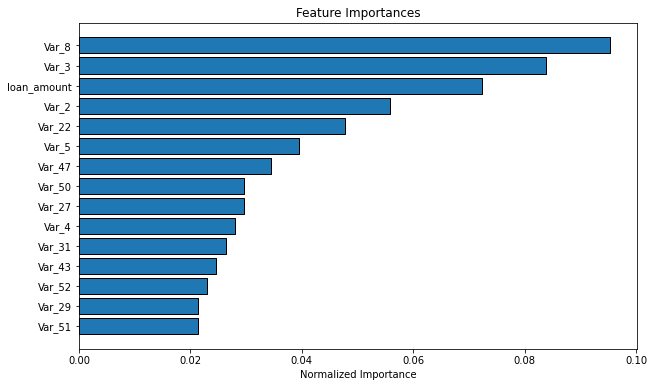

In [146]:
fi_sorted = plot_feature_importances(fi_raw)

In [147]:
submission, fi, metrics = model(train_corrs_removed,test_corrs_removed)

Training Data Shape:  (1715, 38)
Testing Data Shape:  (847, 38)
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.856876	train's binary_logloss: 0.596408	valid's auc: 0.793706	valid's binary_logloss: 0.565544
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[7]	train's auc: 0.86608	train's binary_logloss: 0.598662	valid's auc: 0.786716	valid's binary_logloss: 0.578991
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.858328	train's binary_logloss: 0.597158	valid's auc: 0.77696	valid's binary_logloss: 0.573025
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	train's auc: 0.87485	train's binary_logloss: 0.591767	valid's auc: 0.695068	valid's binary_logloss: 0.594394
Training until validation scores don't impr

In [148]:
metrics

,fold,train,valid
0,0,0.856876,0.793706
1,1,0.866080,0.786716
2,2,0.858328,0.776960
3,3,0.874850,0.695068
4,4,0.882526,0.692721
5,overall,0.867732,0.745857


In [153]:
submission

,loan_application_id,default
0,6,0.486493
1,9,0.532121
2,18,0.423884
3,20,0.361607
4,22,0.454715
...,...,...
842,2551,0.345327
843,2552,0.431465
844,2553,0.500204
845,2557,0.394067


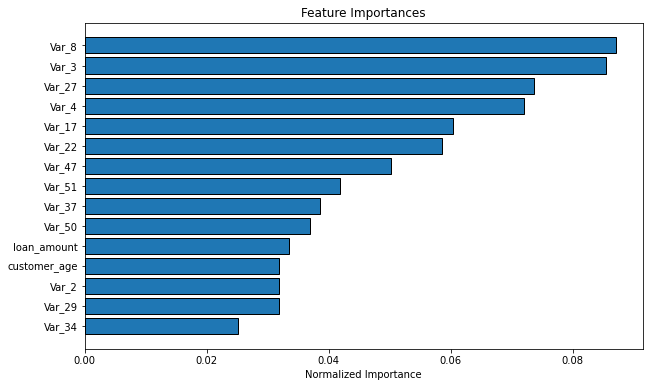

In [149]:
fi_raw_sorted = plot_feature_importances(fi)

In [150]:
print(metrics_raw.iloc[5,:])
print(metrics.iloc[5,:])

fold      overall
train    0.855424
valid    0.750068
Name: 5, dtype: object
fold      overall
train    0.867732
valid    0.745857
Name: 5, dtype: object


## Logistic Regression

In [182]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'default' in app_train:
    train = app_train.drop(columns = ['default','loan_application_id'])
else:
    train = app_train.copy()


    
# Feature names
features = list(train.columns)
ids = app_train['loan_application_id']
test_ids = app_test['loan_application_id']
# Copy of the testing data
test = app_test.drop(columns = ['default', 'loan_application_id'])



# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))




# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (1715, 61)
Testing data shape:  (847, 61)


In [183]:
train_labels = app_train['default']
train.shape

(1715, 61)

In [184]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size = 0.25, random_state = 0)

In [185]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C= 0.01, penalty= 'l2',solver= 'newton-cg',class_weight = 'balanced')

# Train on the training data
log_reg.fit(X_train, y_train)
#log_reg_pred = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

In [186]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
#255 131 6 37
#278 108 17 26 not normalized
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)
#default: 0.5; balanced: 0.760; not-normalized = 0.6624292083383541
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
# default: 0.8012411133871552; balanced: 0.801

257 129 6 37


0.8088926376671888

In [190]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'default' in app_train:
    train_rem = train_corrs_removed.drop(columns = ['default','loan_application_id'])
else:
    train_rem = train_corrs_removed.copy()


    
# Feature names
features = list(train_rem.columns)
ids = train_corrs_removed['loan_application_id']
test_ids = test_corrs_removed['loan_application_id']
# Copy of the testing data
test_rem = test_corrs_removed.drop(columns = ['default', 'loan_application_id'])



# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))




# Repeat with the scaler
scaler.fit(train_rem)
train = scaler.transform(train_rem)
test = scaler.transform(test_rem)

print('Training data shape: ', train_rem.shape)
print('Testing data shape: ', test_rem.shape)

Training data shape:  (1715, 38)
Testing data shape:  (847, 38)


In [ ]:
train_labels = app_train['default']
train.shape

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_rem, train_labels, test_size = 0.25, random_state = 0)

In [193]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C= 0.01, penalty= 'l2',solver= 'newton-cg',class_weight = 'balanced')

# Train on the training data
log_reg.fit(X_train, y_train)
#log_reg_pred = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

In [194]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
#255 131 6 37
#278 108 17 26 not normalized
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)
#default: 0.5; balanced: 0.760; not-normalized = 0.6624292083383541
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
# default: 0.8012411133871552; balanced: 0.801

282 104 12 31


0.7997951560428967

## Random Forest

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size = 0.25, random_state = 0)

In [213]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 5, random_state = 50, verbose = 1, n_jobs = -1,class_weight = 'balanced')
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
#predictions = random_forest.predict_proba(X_test)[:, 1]
predictions = random_forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


In [214]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)
#not-balanced 386 0 42 1
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, predictions))
#default: 0.5; balanced: 0.760; not-normalized = 0.6624292083383541
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, random_forest.predict_proba(X_test)[:,1]))
# default: 0.8012411133871552; balanced: 0.801

381 5 38 5
0.5516628509458971
0.6812567779250512


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


In [215]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_rem, train_labels, test_size = 0.25, random_state = 0)

In [216]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 5, random_state = 50, verbose = 1, n_jobs = -1,class_weight = 'balanced')
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
#predictions = random_forest.predict_proba(X_test)[:, 1]
predictions = random_forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


In [219]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)
#not-balanced 386 0 42 1
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, predictions))
#default: 0.5; balanced: 0.760; not-normalized = 0.6624292083383541
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, random_forest.predict_proba(X_test)[:,1]))
# default: 0.8012411133871552; balanced: 0.801

381 5 38 5
0.5516628509458971
0.6805940474755995


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


# Applying Automated Feature Engineering (Failed)

In [154]:
!pip install featuretools

     |████████████████████████████████| 339 kB 5.1 MB/s 
     |████████████████████████████████| 822 kB 36.2 MB/s 
     |████████████████████████████████| 11.3 MB 39.8 MB/s 
     |████████████████████████████████| 160 kB 48.9 MB/s 
     |████████████████████████████████| 15.7 MB 37.9 MB/s 
     |████████████████████████████████| 1.0 MB 54.7 MB/s 
     |████████████████████████████████| 280 kB 47.0 MB/s 
     |████████████████████████████████| 133 kB 44.3 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Att

In [167]:
app

,loan_application_id,loan_amount,default,customer_age,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_16,Var_17,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_24,Var_25,Var_26,Var_27,Var_28,Var_29,Var_30,Var_31,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,Var_40,Var_41,Var_42,Var_43,Var_44,Var_45,Var_46,Var_47,Var_48,Var_49,Var_50,Var_51,Var_52,Var_53,Var_54,Var_55,Var_56,Var_57,Var_58,Var_59,set,TARGET
0,1,2855.0,0.0,25,3,1,1,37,41,5,5,1330,1,4,0,0,0,17,0,0,13000,1,4,1,4,600.0,0,0,600.0,600,37,1,465,0,600,0,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0.0,0,0,1,1,0,train,NaN
1,2,1577.0,0.0,53,0,0,0,0,26,2,2,1478,1,1,0,0,0,0,0,0,2196,1,1,0,1,0.0,0,0,0.0,0,0,0,0,0,0,0,26.00,203,4300,1,3718,4300,0,0.61,203,4300,3718,203,29,4300,26.00,0,0,0,0,0,0,0.0,0,0,0,1,0,train,NaN
2,3,6858.0,0.0,39,4,2,3,55,58,10,10,1060,3,4,0,0,0,0,0,0,5000,3,4,4,4,1500.0,0,2001,2500.0,2000,55,4,4999,0,10000,2001,13.42,521,14000,1,4120,14000,0,0.35,521,14000,4120,521,36,14000,13.42,521,521,700,0,700,0,700.0,0,0,4,6,0,train,NaN
3,4,2434.5,0.0,49,3,1,3,98,98,11,11,1218,4,7,0,0,0,92,2000,1,7100,4,6,6,7,2450.0,0,0,2450.0,3900,98,2,0,0,4900,15,0.65,296,8100,1,0,8100,0,0.00,296,8100,0,296,36,8100,0.65,296,296,16350,127,16935,0,8467.5,0,0,0,5,0,train,NaN
4,5,4964.0,0.0,47,2,1,1,110,124,15,15,1334,4,6,0,0,0,105,5250,2,3200,4,4,3,6,4100.0,700,0,4100.0,4100,110,1,3116,552,4100,700,21.43,1082,30000,7,38044,81941,0,0.90,1082,30000,38044,2684,225,81941,21.43,1874,2684,3000,142,3400,0,1700.0,0,0,2,10,0,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2551,1990.5,NaN,66,2,1,1,181,181,8,8,1446,4,6,0,0,0,5,20500,1,15500,4,4,4,6,13500.0,0,3447,13500.0,13500,181,1,1650,1650,13500,3447,0.00,0,0,0,0,0,0,0.06,1225,83000,12613,1225,120,83000,31.10,0,1225,0,0,0,0,0.0,0,0,0,2,0,test,NaN
1844,2552,1947.5,NaN,63,1,5,7,51,68,7,7,1410,3,3,0,0,0,0,5500,2,3550,3,1,2,3,5000.0,0,209,5000.0,5000,51,1,130,0,5000,209,22.41,473,13500,2,12828,22500,0,2.26,473,13500,12828,742,84,22500,22.41,269,742,1550,1419,1550,0,1550.0,0,0,0,4,0,test,NaN
1845,2553,3565.5,NaN,53,3,2,3,71,71,5,5,963,0,1,0,0,0,71,0,0,0,0,1,1,1,1173.5,0,340,1173.5,1500,38,2,847,140,2347,340,4.74,168,1800,1,558,1800,0,0.71,168,1800,558,168,12,1800,4.74,168,168,3250,3174,3250,0,3250.0,1242,168,2,4,0,test,NaN
1846,2557,7814.0,NaN,69,1,1,1,36,78,5,5,1668,2,2,0,0,0,0,18000,1,16500,2,1,2,2,3800.0,0,0,3800.0,3800,36,1,0,0,3800,0,9.06,392,8000,1,2702,8000,0,0.13,392,8000,2702,392,24,8000,9.06,392,392,1700,0,1700,0,1700.0,0,0,0,3,0,test,NaN


In [155]:
import featuretools as ft

In [158]:
app_train = app_train.sort_values('loan_application_id').reset_index(drop = True)
app_test = app_test.sort_values('loan_application_id').reset_index(drop = True)

In [ ]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

In [170]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')
# Entities with a unique index
#es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'loan_application_id')

es = es.add_dataframe(
    dataframe_name="app",
    dataframe=app,
    index="loan_application_id",
  
)

es

Entityset: clients
  DataFrames:
    app [Rows: 1848, Columns: 65]
  Relationships:
    No relationships

In [172]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,std,aggregation,True,True,"Computes the dispersion relative to the mean value, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
1,median,aggregation,False,False,Determines the middlemost number in a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
2,avg_time_between,aggregation,False,False,Computes the average number of seconds between consecutive events.,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
3,percent_true,aggregation,True,False,Determines the percent of `True` values.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
4,num_unique,aggregation,True,True,"Determines the number of distinct values, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['category'])>,None
5,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
6,trend,aggregation,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Datetime) (Semantic ...",None
7,mean,aggregation,True,True,Computes the average for a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
8,time_since_last,aggregation,False,False,Calculates the time elapsed since the last datetime (default in seconds).,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
9,count,aggregation,True,True,"Determines the total number of values, excluding `NaN`.",<ColumnSchema (Semantic Tags = ['index'])>,None


In [173]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
22,equal,transform,True,True,Determines if values in one list are equal to another list.,<ColumnSchema>,None
23,modulo_by_feature,transform,True,True,Return the modulo of a scalar by each element in the list.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
24,not,transform,True,True,Negates a boolean value.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
25,time_since_previous,transform,False,False,Compute the time since the previous entry in a list.,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
26,diff,transform,False,False,Compute the difference between the value in a list and the,<ColumnSchema (Semantic Tags = ['numeric'])>,None
27,is_null,transform,True,True,Determines if a value is null.,<ColumnSchema>,None
28,less_than_equal_to,transform,True,True,Determines if values in one list are less than or equal to another list.,"<ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Ordinal)>, <ColumnSc...",None
29,modulo_numeric,transform,True,True,Element-wise modulo of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
30,divide_numeric_scalar,transform,True,True,Divide each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
31,geomidpoint,transform,False,False,Determines the geographic center of two coordinates.,<ColumnSchema (Logical Type = LatLong)>,None


In [174]:
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "numwords", "characters"]

# Results


*  At the start, we had 61 different columns in our data. We removed highly coorelated columns(correlation value >0.8, <-0.8) and we end up with 38 columns. So 23 columns are eleminated.




*  We run the LightGBM, Logistic Regression and Random Forest models with the reduced dataframe and looked if the performance is increased.

**LightGBM**

Default Data:
train score:   0.855424,
valid score:   0.750068,

Reduced Data:
train score:    0.867732,
valid score:  0.745857


**Logistic Regression(No validation data)**


Default Data: 0.8088

Reduced Data: 0.7997

**Random Forest(No validation data)**



Default Data: 0.7411

Reduced Data: 0.7833








# Conclusion and Further Work


Looks like, we couldn't manage to increase the performance. However, we managed to get almost the same results with reduced dataset, which means that we managed to decrease the dimension significantly. It might help to solve curse of dimensinality problem for KNN models.

---

At the last part, I tried to implement automated feature engeering by using Python library *featuretools* But, I couldn't finish it. It would be good comparison to compare the manuel feature engineering and automated feature engineering. According to researches, manuel feature engieering is still a few steps ahead but one day automated feature engineering might take the lead.



